# PyTorch Regression



In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
torch.__version__

'2.6.0+cu124'

## 1. Data (preparing and loading)

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data into training and test sets

In [3]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

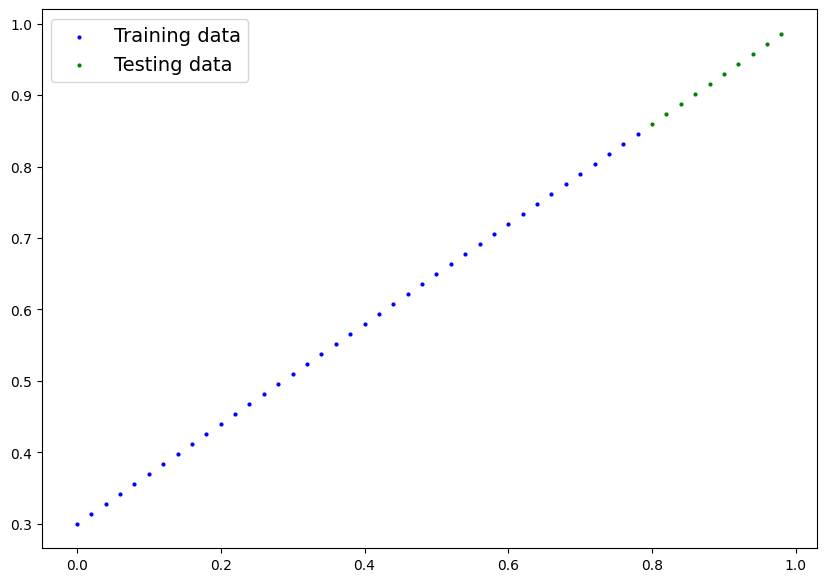

In [5]:
plot_predictions();

# Model initilization

## Linear Regression

$ \hat{y} = x^\top w + b$

## Loss functions

### Root mean squared error

$ \mathcal{L}_{RMSE} = \sqrt{\frac{1}{2 * N} \sum_{i = 1}^N (y_{i}  - \hat{y}_{i} ) ^ 2} $

### Mean absolute error

$ \mathcal{L}_{MAE} = \frac{1}{2 * N} \sum_{i = 1}^N | y_{i}  - \hat{y}_{i}| $

## L1 reg

$ \mathcal{L}_{l1} = \mathcal{L} +  \frac{\lambda}{2} \sum_{j = 1}^M |w_j|$

## L2 reg

$ \mathcal{L}_{l2} = \mathcal{L} +  \frac{\lambda}{2} \sum_{j = 1}^M w_j ^2$

## Tasks
1. Implement linear regression using the formulas above;
2. Implement RMSE and MAE (you can use both for optimization)

## Notes:
1. The `nn.Module` registeres a forward pass hook based on whatever `forward` method you define. Do not forget to call the super constructor, as your `Module` will not work properly!
2. You can later call it as a python function, e.g. `model(*args, **kwargs)`, based on your `forward` implementation.
3. For the loss function you can either use your own implementation, or the one provided from PyTorch ([Losses](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)).
4. Do not use the `nn.Linear` to define your parameters for this assignment, albeit in practice it is more convinient!
5. You'll most probabily need to check the `torch.nn.Parameter`'s documentation.


In [27]:
class LinearRegression(nn.Module):

  def __init__(self, features_size):
    super(LinearRegression, self).__init__()

    w = np.random.uniform(-1, 1, size=features_size).reshape(-1, 1).astype(np.float32)
    self.w = torch.nn.Parameter(torch.tensor(w), requires_grad=True)
    self.b = torch.nn.Parameter(torch.tensor(0.), requires_grad=True)

  def forward(self, X):
    y_hat = torch.mm(X, self.w) + self.b
    return y_hat

model = LinearRegression(X_train.shape[1])

In [28]:
# Subclass nn.Module to make our model
class LinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    def forward(self, x):
        return self.linear_layer(x)

In [29]:
next(iter(model.parameters()))

Parameter containing:
tensor([[0.3738]], requires_grad=True)

In [30]:
list(model.parameters())

[Parameter containing:
 tensor([[0.3738]], requires_grad=True),
 Parameter containing:
 tensor(0., requires_grad=True)]

In [31]:

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

torch.manual_seed(42)

mse = nn.MSELoss()
mae = nn.L1Loss()
list(model.parameters())

[Parameter containing:
 tensor([[0.3738]], requires_grad=True),
 Parameter containing:
 tensor(0., requires_grad=True)]

We can also get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict).

In [32]:
model.state_dict()

OrderedDict([('w', tensor([[0.3738]])), ('b', tensor(0.))])

In [33]:
with torch.inference_mode():
    y_preds = model(X_test)

In [34]:
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.2990],
        [0.3065],
        [0.3140],
        [0.3215],
        [0.3289],
        [0.3364],
        [0.3439],
        [0.3514],
        [0.3588],
        [0.3663]])


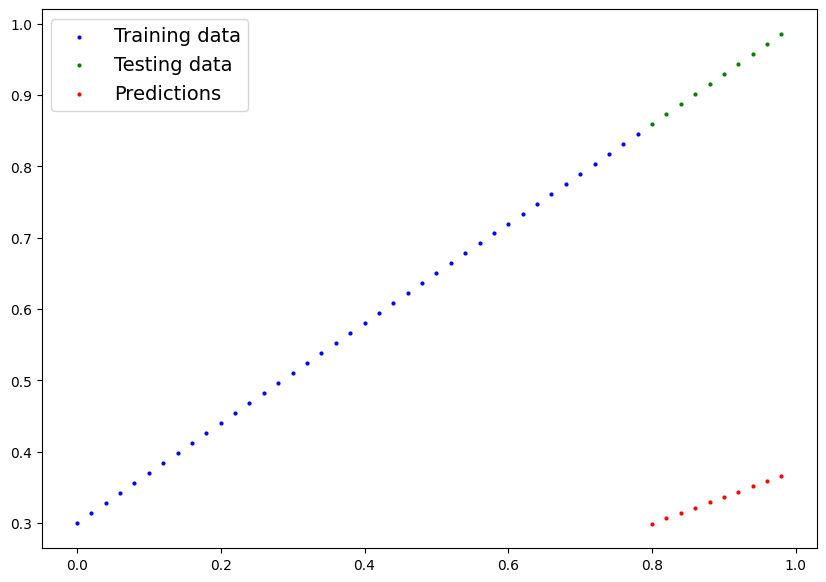

In [36]:
plot_predictions(predictions=y_preds)

In [38]:
y_test - y_preds

tensor([[0.5610],
        [0.5675],
        [0.5740],
        [0.5805],
        [0.5871],
        [0.5936],
        [0.6001],
        [0.6066],
        [0.6132],
        [0.6197]])

## 3. Train model

In [39]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [40]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.42722153663635254 | MAE Test Loss: 0.5714592933654785 
Epoch: 10 | MAE Train Loss: 0.2884298264980316 | MAE Test Loss: 0.38289594650268555 
Epoch: 20 | MAE Train Loss: 0.14977684617042542 | MAE Test Loss: 0.19452086091041565 
Epoch: 30 | MAE Train Loss: 0.011262534186244011 | MAE Test Loss: 0.006334275007247925 
Epoch: 40 | MAE Train Loss: 0.0354122631251812 | MAE Test Loss: 0.03366079181432724 
Epoch: 50 | MAE Train Loss: 0.017997274175286293 | MAE Test Loss: 0.031843073666095734 
Epoch: 60 | MAE Train Loss: 0.009919698350131512 | MAE Test Loss: 0.004903727676719427 
Epoch: 70 | MAE Train Loss: 0.0029510348103940487 | MAE Test Loss: 0.003447633935138583 
Epoch: 80 | MAE Train Loss: 0.004554148763418198 | MAE Test Loss: 0.0068080248311161995 
Epoch: 90 | MAE Train Loss: 0.0020622783340513706 | MAE Test Loss: 0.0014096021186560392 


Oh would you look at that! Looks like our loss is going down with every epoch, let's plot it to find out.

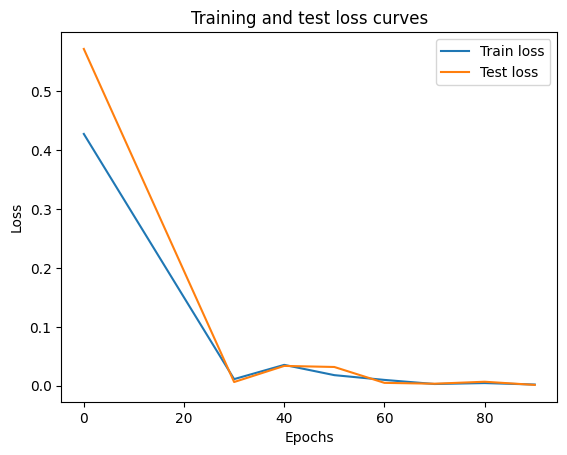

In [41]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [42]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('w', tensor([[0.6984]])), ('b', tensor(0.2989))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [43]:
model.eval()

with torch.inference_mode():

  y_preds = model(X_test)
y_preds

tensor([[0.8576],
        [0.8716],
        [0.8855],
        [0.8995],
        [0.9135],
        [0.9274],
        [0.9414],
        [0.9554],
        [0.9694],
        [0.9833]])

Nice! We've made some predictions with our trained model, now how do they look?

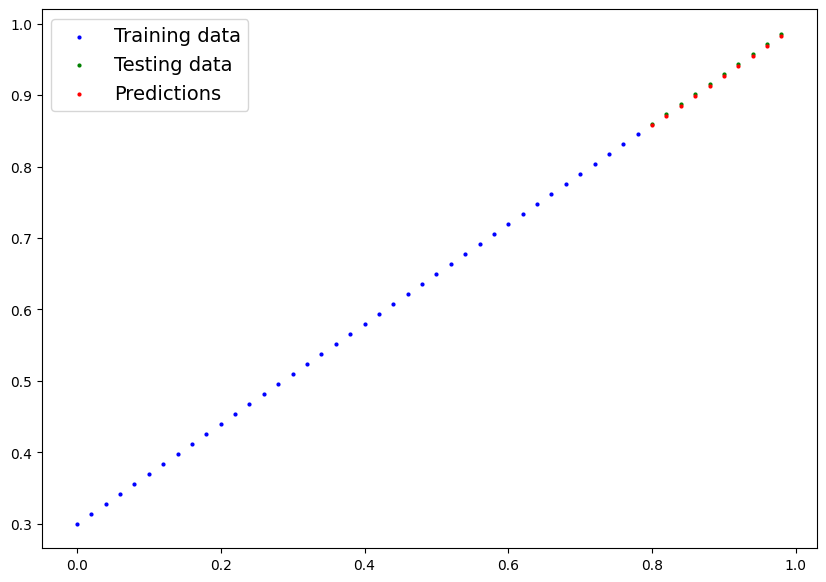

In [44]:
plot_predictions(predictions=y_preds)

## Saving and loading a PyTorch model



In [ ]:
MODEL_PATH = ""

MODEL_NAME = "model"
MODEL_SAVE_PATH = MODEL_PATH + MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: model


In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LinearRegression(X_train.shape[1])

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-25-6515cf345212>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) # perform a forward pass on the test data with the loaded model

In [ ]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.5.1+cu124'

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Excellent, let's visualize them to make sure they look okay.

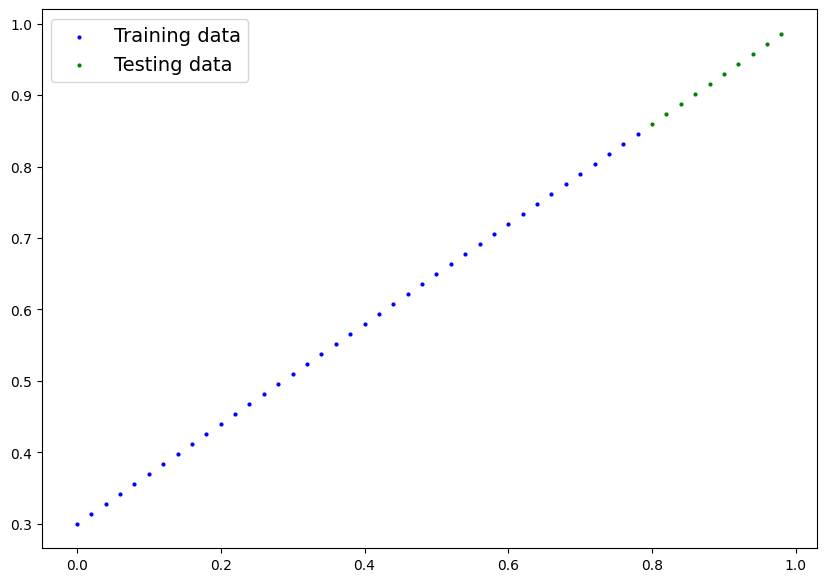

In [ ]:
# Note: If you've reset your runtime, this function won't work,
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

In [ ]:
# Subclass nn.Module to make our model
class LinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    def forward(self, x):
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionV2()
model_1, model_1.state_dict()

(LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

In [ ]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.AdamW(params=model_1.parameters(),
                              lr=0.01)

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5683961510658264
Epoch: 100 | Train loss: 0.014988409355282784 | Test loss: 0.028366362676024437
Epoch: 200 | Train loss: 0.002427533967420459 | Test loss: 0.0032408477272838354
Epoch: 300 | Train loss: 0.0014569759368896484 | Test loss: 0.0015379845863208175
Epoch: 400 | Train loss: 0.0011451765894889832 | Test loss: 0.0017451643943786621
Epoch: 500 | Train loss: 0.0012771167093887925 | Test loss: 0.00029590129270218313
Epoch: 600 | Train loss: 0.00023328512907028198 | Test loss: 0.0026540399994701147
Epoch: 700 | Train loss: 0.0014367826515808702 | Test loss: 0.001246458268724382
Epoch: 800 | Train loss: 0.00023701861209701747 | Test loss: 6.201267387950793e-05
Epoch: 900 | Train loss: 0.0004802465555258095 | Test loss: 0.000821959984023124


In [ ]:
from pprint import pprint
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.7021]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3015], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8632],
        [0.8772],
        [0.8913],
        [0.9053],
        [0.9194],
        [0.9334],
        [0.9475],
        [0.9615],
        [0.9755],
        [0.9896]], device='cuda:0')

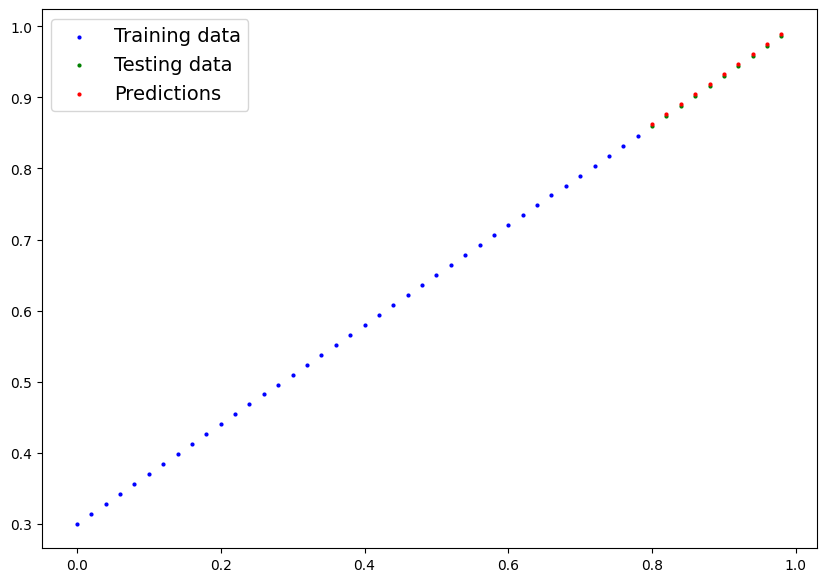

In [ ]:
plot_predictions(predictions=y_preds.cpu())

In [ ]:
MODEL_PATH = ""

MODEL_NAME = "model"
MODEL_SAVE_PATH = MODEL_PATH + MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: model


In [ ]:
loaded_model_1 = LinearRegressionV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')